In [34]:
##### import stuff ###### 
import numpy as np 
import pandas as pd 
from covid19dh import covid19
from datetime import date
from Get_covid_data import get_data
import pymc3 as pm
import pandas as pd 
import numpy as np 
import seaborn as sns
import arviz as az
import matplotlib.pyplot as plt
import os 
import theano
import theano.tensor as tt 
import random
import fns as f

In [35]:
##### generate data #####
###### .... ###### 
time = np.arange(0, 30, 1) 
time_true = np.append([time, time], time)

# Amplitude of the sine wave is sine of a variable like time
sines1 = np.sin(0.9*time) + np.random.normal(0, 0.2, 30)
sines2 = np.sin(time) + np.random.normal(0, 0.3, 30)
sines3 = np.sin(1.1*time) + np.random.normal(0, 0.2, 30)
coses1 = np.cos(0.9 * time) + np.random.normal(0, 0.2, 30)
coses2 = np.cos(time) + np.random.normal(0, 0.4, 30)
coses3 = np.cos(1.1 * time) + np.random.normal(0, 0.2, 30)
line1 = 1 + 0.5 * time + np.random.normal(0, 0.2, 30) 
line2 = 0.5 + 0.3 * time + np.random.normal(0, 0.2, 30)
line3 = 3 + 1 * time + np.random.normal(0, 0.2, 30)

y1 = sines1 + coses1 + line1
y2 = sines2 + coses2 + line2
y3 = sines3 + coses3 + line3

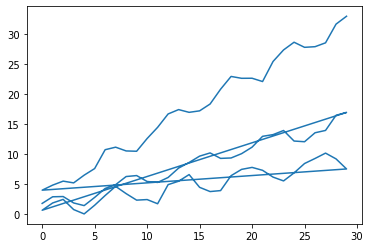

In [36]:
y_true = np.append([y1, y2], y3)
idx_true = np.append(
    [np.zeros(30, dtype = int), 
    np.ones(30, dtype = int)],
    np.ones(30, dtype = int) + 1)

plt.plot(time_true, y_true)

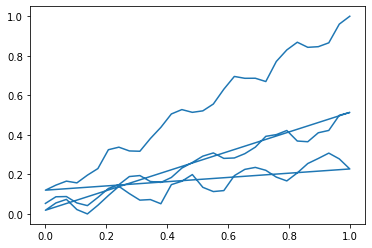

In [37]:
#### parameters ####
n_idx = len(np.unique(idx_true))
n_components = 3
# consider whether it should be time_true + 1
p_week_mu = (7 - time_true.min()) / (time_true.max() - time_true.min())
p_week_sd = (2 - time_true.min()) / (time_true.max() - time_true.min())
beta_week_sd = 0.1

## scale stuff
time_true_scaled = (time_true - time_true.min()) / (time_true.max() - time_true.min())
time_scaled = (time - time.min()) / (time.max() - time.min())
# each individually?
y_true_scaled = (y_true - y_true.min()) / (y_true.max() - y_true.min())
plt.plot(time_true_scaled, y_true_scaled)

In [38]:
#### model #### 
with pm.Model() as m0: 
    
    # shared 
    t_shared = pm.Data('t_shared', time_true_scaled)
    idx_shared = pm.Data('idx_shared', idx_true)
    
    # prepare fourier 
    p_1_week = pm.Normal("p_1", mu = p_week_mu, sd = p_week_sd, shape = n_idx)
    period_x_week = 2*np.pi*np.arange(1, n_components+1)
    period_stack_week = np.stack([period_x_week, period_x_week, period_x_week])
    period_scaled_week = period_stack_week.T / p_1_week
    x_week = tt.reshape(period_scaled_week[:, :, None] * time_scaled, (n_components, n_idx*len(time_scaled)))
    x_week_waves = tt.concatenate((tt.cos(x_week), tt.sin(x_week)), axis=0)
    

    # beta
    beta_week_waves = pm.Normal('beta_week_waves', mu = 0, 
                                sd = beta_week_sd, shape = (2*n_components, n_idx)) 
    beta_line = pm.Normal('beta_line', mu = 0, sd = 0.1, shape = n_components)
    alpha = pm.Normal('alpha', mu = 0, sd = 0.1, shape = n_components)
    
    # loop for waves. 
    week_lst = []
    index_first = 0
    index_second = len(time_scaled)
    for i in range(n_idx): 
        week_tmp = pm.math.dot(x_week_waves.T[index_first:index_second, :], beta_week_waves[:, i])
        week_lst.append(week_tmp)
        index_first += len(time_scaled)
        index_second += len(time_scaled)
        
    week_stacked = tt.stack(week_lst)
    week_flat = tt.flatten(week_stacked)
    
    #pm.math.dot(test2, alpha[idx_shared])
    #pm.math.dot(test, beta_line[idx_shared])
    mu = alpha[idx_shared] + beta_line[idx_shared] * t_shared + week_flat
    
    # sigma 
    sigma = pm.Exponential('sigma', 1)
    
    # likelihood 
    y_pred = pm.Normal('y_pred', 
                       mu = mu,
                       sd = sigma,
                       observed = y_true_scaled)


<AxesSubplot:xlabel='y_pred'>

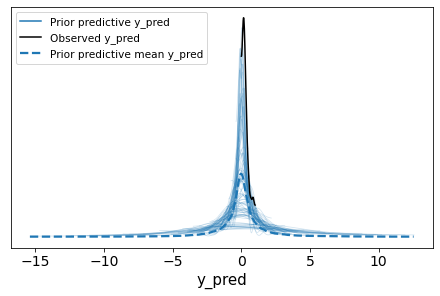

In [39]:
## prior sampling 
with m0:
    prior_pred = pm.sample_prior_predictive(100) # like setting this low. 
    m0_idata = az.from_pymc3(prior=prior_pred)

az.plot_ppc(m0_idata, group="prior")


In [40]:
## sample everything 
# convenience function 
def sample_mod(
    model, 
    posterior_draws = 1000, 
    post_pred_draws = 1000,
    prior_pred_draws = 500):
    
    with model: 
        trace = pm.sample(
            return_inferencedata = False, 
            draws = posterior_draws,
            target_accept = .95) # tuning!
        post_pred = pm.sample_posterior_predictive(trace, samples = post_pred_draws)
        prior_pred = pm.sample_prior_predictive(samples = prior_pred_draws)
        m_idata = az.from_pymc3(trace = trace, posterior_predictive=post_pred, prior=prior_pred)
    
    return m_idata

m0_idata = sample_mod(m0)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, beta_line, beta_week_waves, p_1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 130 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
C:\Users\emilr\Anaconda3\envs\CM\lib\site-packages\pymc3\sampling.py:1688: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


posterior predictive variable y_pred's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


<AxesSubplot:xlabel='y_pred'>

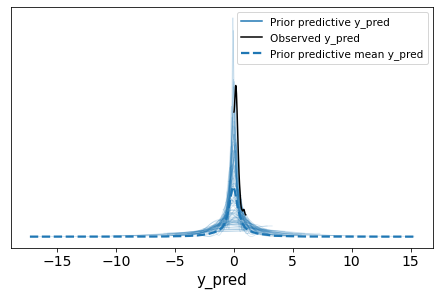

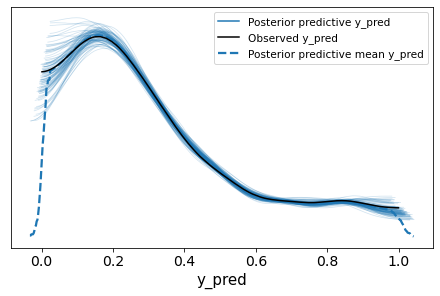

In [41]:
## plot checks 
az.plot_ppc(m0_idata, num_pp_samples = 100, group = "prior")
az.plot_ppc(m0_idata, num_pp_samples = 100)

array([[<AxesSubplot:title={'center':'p_1'}>,
        <AxesSubplot:title={'center':'p_1'}>],
       [<AxesSubplot:title={'center':'beta_week_waves'}>,
        <AxesSubplot:title={'center':'beta_week_waves'}>],
       [<AxesSubplot:title={'center':'beta_line'}>,
        <AxesSubplot:title={'center':'beta_line'}>],
       [<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

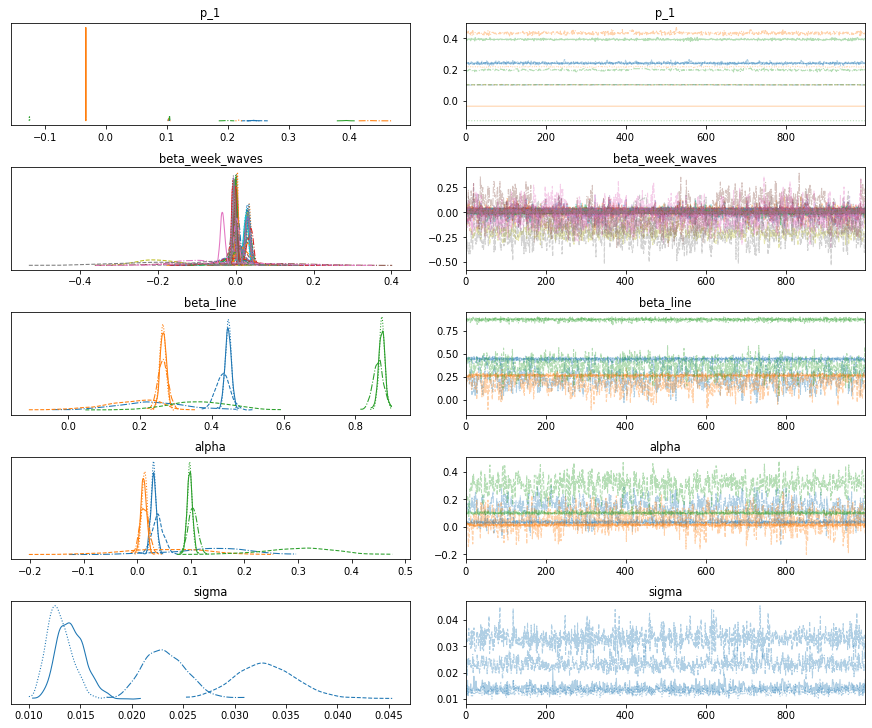

In [42]:
## plot trace
az.plot_trace(m0_idata)

In [43]:
## fit to data
m_pred = m0_idata.posterior_predictive.mean(axis = 1)
m_pred = m_pred.mean(axis = 0)

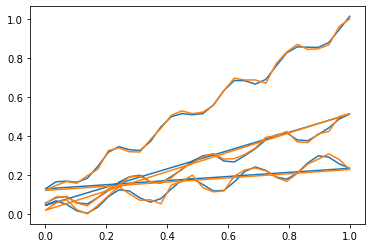

In [44]:
# try to plot it 
plt.plot(time_true_scaled, m_pred["y_pred"])
plt.plot(time_true_scaled, y_true_scaled)